## Things to continue
* Add lgb, cat and xgb
* Perform feature selection with sklearn.RFE
* Analyze least k important features

In [1]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import lightgbm as lgb
from catboost import CatBoostRegressor
from exp.run import run_experiment
from exp.mappings import alg_map
from exp.train import train_model

## Load hypers result

In [2]:
save_results = "exp2.csv"

In [3]:
score_df = pd.read_csv(save_results)
score_df = score_df.sort_values(by="score", axis=0)
print("\nThe number of type of models: {}\nThe total number of results: {}".
      format(score_df.alg.nunique(), len(score_df.index)))
score_df.head(10)


The number of type of models: 13
The total number of results: 245


,alg,score,mad,params_json
168,rfreg,2.036773,0.101385,"{""criterion"": ""mae"", ""max_depth"": 5, ""n_estima..."
166,rfreg,2.037550,0.053299,"{""criterion"": ""mae"", ""max_depth"": 5, ""n_estima..."
164,rfreg,2.041128,0.093568,"{""criterion"": ""mae"", ""max_depth"": 5, ""n_estima..."
167,rfreg,2.047406,0.079818,"{""criterion"": ""mae"", ""max_depth"": 5, ""n_estima..."
1,svr,2.056577,0.079078,"{""C"": 10.0, ""gamma"": 0.001, ""kernel"": ""rbf"", ""..."
23,svr,2.059389,0.056404,"{""C"": 1.0, ""gamma"": ""auto"", ""kernel"": ""rbf"", ""..."
149,rfreg,2.061523,0.053086,"{""criterion"": ""mse"", ""max_depth"": 5, ""n_estima..."
6,svr,2.062657,0.054858,"{""C"": 1.0, ""gamma"": ""auto"", ""kernel"": ""rbf"", ""..."
165,rfreg,2.063265,0.069514,"{""criterion"": ""mae"", ""max_depth"": 5, ""n_estima..."
182,etreg,2.063431,0.049709,"{""criterion"": ""mse"", ""max_depth"": 10, ""n_estim..."


In [4]:
indx = score_df.groupby("alg").idxmin()["score"]
best_scores_df = score_df.loc[indx,]
best_scores_df.index = best_scores_df.alg.map(lambda x: alg_map[x].__name__)
best_scores_df["model"] = best_scores_df.alg.map(lambda x: alg_map[x])
display(best_scores_df[['score', 'params_json']].sort_values("score"))

,score,params_json
alg,,
RandomForestRegressor,2.036773,"{""criterion"": ""mae"", ""max_depth"": 5, ""n_estima..."
SVR,2.056577,"{""C"": 10.0, ""gamma"": 0.001, ""kernel"": ""rbf"", ""..."
ExtraTreesRegressor,2.063431,"{""criterion"": ""mse"", ""max_depth"": 10, ""n_estim..."
BaggingRegressor,2.069047,"{""max_samples"": 0.2, ""n_estimators"": 200}"
NuSVR,2.072535,"{""C"": 1.0, ""gamma"": ""auto"", ""kernel"": ""rbf"", ""..."
GradientBoostingRegressor,2.074061,"{""criterion"": ""mae"", ""learning_rate"": 0.5, ""lo..."
MLPRegressor,2.099988,"{""activation"": ""relu"", ""batch_size"": 32, ""hidd..."
AdaBoostRegressor,2.106145,"{""learning_rate"": 0.5, ""loss"": ""exponential"", ..."
KNeighborsRegressor,2.123703,"{""leaf_size"": 30, ""n_neighbors"": 20, ""p"": 1, ""..."


In [11]:
trees = ["AdaBoostRegressor", "DecisionTreeRegressor", "ExtraTreesRegressor",
        "GradientBoostingRegressor", "RandomForestRegressor"]
l1_based = ["Logits"] 

In [6]:
print("Treebased in the searching: {}".format(trees))
print("\nL1-based: {}".format(l1_based))

Treebased in the searching: ['AdaBoostRegressor', 'DecisionTreeRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'RandomForestRegressor']

L1-based: ['Logits']


## Create Training Features

In [7]:
X_save = "X_tr.csv"
y_save = "y_tr.csv"
X_save_scaled = "X_tr_scaled.csv"
scale_params_pickle = "scale_params.pickle"
other_params_json = "other.json"
tr_scaler = None
classic_sta_lta5_mean_fill = None
classic_sta_lta7_mean_fill = None

if not (os.path.exists(X_save_scaled) and os.path.exists(y_save)):
    if os.path.exists(X_save) and os.path.exists(y_save):
        X_tr = pd.read_csv(X_save, index_col=0)
        y_tr = pd.read_csv(y_save, index_col=0)

        scale_params_pickle_on = open(scale_params_pickle, "rb")
        tr_scaler = pickle.load(scale_params_pickle_on)
        scale_params_pickle_on.close()
        
        X_train_scaled = pd.DataFrame(tr_scaler.transform(X_tr), columns=X_tr.columns)
        X_train_scaled.to_csv(X_save_scaled)
    else:
        X_tr, X_train_scaled, y_tr, tr_scaler, classic_sta_lta5_mean_fill, classic_sta_lta7_mean_fill  = create_train_features(r'C:\Users\arvin\dev\lanl\train.csv')
        X_tr.to_csv(X_save)
        y_tr.to_csv(y_save)
        X_train_scaled.to_csv(X_save_scaled)

        scale_params_pickle_on = open(scale_params_pickle, "wb")
        pickle.dump(tr_scaler, scale_params_pickle_on)
        scale_params_pickle_on.close()

        with open(other_params_json, 'w') as fp:
            json.dump({"classic_sta_lta5_mean_fill": classic_sta_lta5_mean_fill,
                       "classic_sta_lta7_mean_fill": classic_sta_lta7_mean_fill}, fp)
else:
    X_train_scaled = pd.read_csv(X_save_scaled, index_col=0)
    y_tr = pd.read_csv(y_save, index_col=0)

In [8]:
X_train_scaled.head()

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140,-0.170214,-0.218194,0.193218,-1.326420,-1.569265,-0.222567,0.0,0.052067,-0.285579,...,0.268470,-0.004742,0.178278,0.287332,0.965402,1.509153,0.885262,-0.631300,-1.832422,-0.004742
1,0.805716,0.004734,0.063936,-0.018037,0.002747,-1.040206,0.036797,0.0,0.153858,-0.076987,...,-0.141264,0.007341,-0.025387,0.622391,0.842747,0.522428,0.294357,-0.912054,-0.890022,0.007341
2,1.511155,0.049252,-0.086289,0.163039,-0.218781,0.949925,-0.101306,0.0,0.004241,0.277885,...,0.085078,0.099556,0.245184,0.634878,1.207106,1.530919,0.889790,0.441128,0.639209,0.099556
3,1.494934,0.043950,0.122560,-0.187796,0.002747,-0.634909,0.097427,0.0,0.020852,-0.058805,...,0.083085,0.068076,0.105059,0.770151,1.160208,1.432972,0.815078,-0.949994,-1.097513,0.068076
4,1.520242,0.088495,-0.067969,0.087590,-0.108017,0.094279,-0.084464,0.0,-0.093104,0.174161,...,-0.164151,0.138032,0.187535,1.040695,1.557034,1.393068,0.901110,0.595416,-0.465464,0.138032


In [9]:
print("Train feature: {}".format(X_train_scaled.shape))
print("Train label: {}".format(y_tr.shape))

Train feature: (4194, 138)
Train label: (4194, 1)


## FI-Treebased
* AdaBoosting
* ExtraTree
* GradientBoosting
* RandomForest
* lgboosting
* catboosting?
* xgboosting?

In [12]:
feature_importance_df = pd.DataFrame()
feature_importance_df["features"] = X_train_scaled.columns

for alg in trees: 
    cls = best_scores_df.loc[alg, "model"]
    params_json = best_scores_df.loc[alg, "params_json"]
    print("alg: {}".format(cls))
    print("params_json: {}".format(params_json))
    params = json.loads(params_json)
    # initialize model
    model = cls(**params)

    # train algorithm
    model.fit(X_train_scaled, y_tr)
    feature_importance_df[alg] = model.feature_importances_


alg: <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>
params_json: {"learning_rate": 0.5, "loss": "exponential", "n_estimators": 5}
alg: <class 'sklearn.tree.tree.DecisionTreeRegressor'>
params_json: {"criterion": "friedman_mse", "max_depth": 5, "splitter": "best"}
alg: <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
params_json: {"criterion": "mse", "max_depth": 10, "n_estimators": 200}
alg: <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
params_json: {"criterion": "mae", "learning_rate": 0.5, "loss": "lad", "max_depth": 3, "n_estimators": 10, "subsample": 1.0}
alg: <class 'sklearn.ensemble.forest.RandomForestRegressor'>
params_json: {"criterion": "mae", "max_depth": 5, "n_estimators": 50}


In [19]:
# retrieve relevant value
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
}
model = lgb.LGBMRegressor(**params, n_estimators = 5000, n_jobs = -1)
model.fit(X_train_scaled, y_tr, verbose=True)
feature_importance_df["LGBMRegressor"] = model.feature_importances_ / sum(model.feature_importances_)

In [20]:
trees.append("LGBMRegressor")
display(feature_importance_df.sort_values("RandomForestRegressor", ascending=False))

,features,AdaBoostRegressor,DecisionTreeRegressor,ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor,LGBMRegressor
99,q05_roll_std_100,0.678973,0.834000,0.086476,0.439505,0.605574,0.014403
77,q05_roll_std_10,0.173235,0.000000,0.124114,0.000000,0.160534,0.012474
121,q05_roll_std_1000,0.084037,0.088321,0.073802,0.033340,0.056637,0.013664
98,q01_roll_std_100,0.000000,0.000000,0.057163,0.009646,0.009680,0.010151
131,q01_roll_mean_1000,0.002314,0.002334,0.002870,0.004403,0.007467,0.008936
120,q01_roll_std_1000,0.015966,0.000000,0.034171,0.108408,0.005189,0.011936
24,max_to_min,0.000000,0.000000,0.003046,0.000000,0.005172,0.015136
132,q05_roll_mean_1000,0.000000,0.002842,0.002512,0.000000,0.004739,0.005824
12,avg_first_50000,0.002771,0.004466,0.002499,0.000000,0.004622,0.008579
112,q99_roll_mean_100,0.000000,0.000000,0.002391,0.000000,0.004578,0.009481


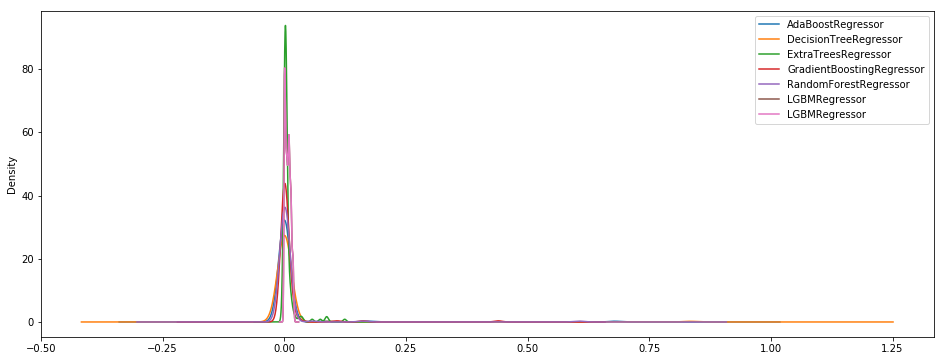

In [21]:
feature_importance_df[trees].plot.kde(bw_method=0.2, figsize=(16,6)) 

__Comment:__ 
* ExtraTrees and LGB tend not to select certain features.
* For all the tree-based model, they tend to only use a few features.

In [22]:
# Top 10 features used most by each model
top_features = set()
for col in trees:
    feats = feature_importance_df.sort_values(col,ascending=False)[:10]
    top_features.update(feats.features.values)
print(len(top_features))

35


In [23]:
#list(top_features)
best_features_df = feature_importance_df.loc[feature_importance_df.features.isin(list(top_features))]
best_features_long_df = pd.melt(best_features_df, id_vars='features', value_vars=trees)
best_features_long_df.head()

,features,variable,value
0,avg_first_50000,AdaBoostRegressor,0.002771
1,max_to_min,AdaBoostRegressor,0.000000
2,mean_change_rate_last_50000,AdaBoostRegressor,0.000000
3,mean_change_rate_first_10000,AdaBoostRegressor,0.000000
4,mean_change_rate_last_10000,AdaBoostRegressor,0.000000


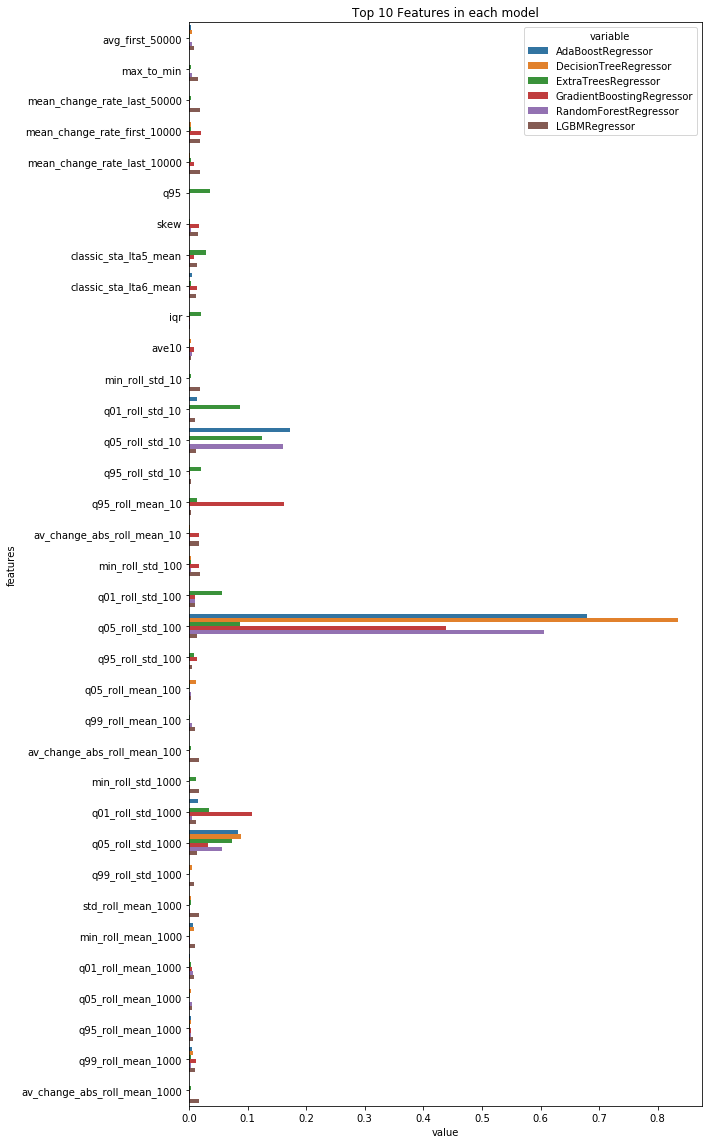

In [24]:
plt.figure(figsize=(10,16))
sns.barplot(x="value", y="features", data=best_features_long_df, hue="variable")
plt.title('Top 10 Features in each model')
plt.tight_layout()
#plt.savefig('ada_importances.png')

__Comment:__
* Features with use most often: q05_roll_std_100, q05_roll_std_1000, q01_roll_std_1000,q05_roll_std_10
* ExtraTree tend to use more features
* Both RandomForest and AdaBoosting tend to use less features

In [25]:
corr = best_features_df.corr()
corr

,AdaBoostRegressor,DecisionTreeRegressor,ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor,LGBMRegressor
AdaBoostRegressor,1.000000,0.967885,0.570919,0.880699,0.998856,0.111566
DecisionTreeRegressor,0.967885,1.000000,0.412085,0.911889,0.965898,0.101327
ExtraTreesRegressor,0.570919,0.412085,1.000000,0.373355,0.557723,-0.030061
GradientBoostingRegressor,0.880699,0.911889,0.373355,1.000000,0.876926,0.038201
RandomForestRegressor,0.998856,0.965898,0.557723,0.876926,1.000000,0.109483
LGBMRegressor,0.111566,0.101327,-0.030061,0.038201,0.109483,1.000000


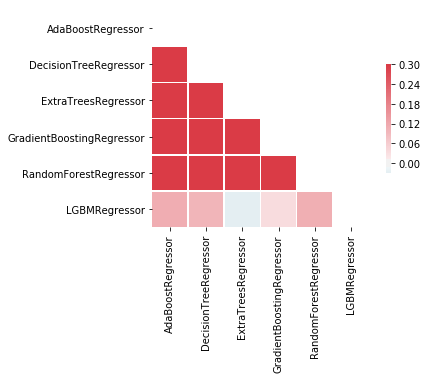

In [26]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

__Comment:__
* The way LGBRegressor selecting features seems to be quite difference from other

## L1-Based
* Lasso
* Lasso_cv

In [48]:
# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
k_folds = [3, 5, 10]
feature_coefs_df = pd.DataFrame()
feature_coefs_df["features"] = X_train_scaled.columns

k_coefs = []
for k in k_folds:
    clf = LassoCV(eps=0.001, n_alphas=100, alphas=None, cv=k)
    model = clf.fit(X_train_scaled, y_tr)
    print("The best alpha chosen by cv with {} folds: {}".format(k, model.alpha_))
    k_coefs.append(str(k)+"_abcoef")
    feature_coefs_df[str(k)+"_coef"] = model.coef_
    feature_coefs_df[str(k)+"_abcoef"] = np.abs(model.coef_)

The best alpha chosen by cv with 3 folds: 0.09619978059284225
The best alpha chosen by cv with 5 folds: 0.012717044843908187
The best alpha chosen by cv with 10 folds: 0.012717044843908187


In [49]:
feature_coefs_df.sort_values("3_abcoef", ascending=False)[[
        "features", "3_abcoef", "5_abcoef", "10_abcoef"
    ]].head(30)

,features,3_abcoef,5_abcoef,10_abcoef
99,q05_roll_std_100,0.863731,2.046061,2.046061
77,q05_roll_std_10,0.593470,1.045964,1.045964
76,q01_roll_std_10,0.494934,0.456973,0.456973
98,q01_roll_std_100,0.375055,0.000000,0.000000
131,q01_roll_mean_1000,0.227622,0.000000,0.000000
41,abs_trend,0.101346,0.275469,0.275469
97,min_roll_std_100,0.060637,0.115507,0.115507
54,classic_sta_lta5_mean,0.025924,0.000000,0.000000
23,max_last_10000,0.020163,0.003859,0.003859
8,std_first_50000,0.004854,0.000000,0.000000


In [54]:
# Top 10 features used most by each model
top_features = set()
for col in k_coefs:
    feats = feature_coefs_df.sort_values(col,ascending=False)[:10]
    top_features.update(feats.features.values)
print(len(top_features))

15


In [55]:
best_features_coefs_df = feature_coefs_df.loc[feature_coefs_df.features.isin(list(top_features))]
best_features_clong_df = pd.melt(best_features_coefs_df, id_vars='features', value_vars=k_coefs)
best_features_clong_df.head()

,features,variable,value
0,std_first_50000,3_abcoef,0.004854
1,max_last_10000,3_abcoef,0.020163
2,abs_q95,3_abcoef,0.000000
3,abs_trend,3_abcoef,0.101346
4,classic_sta_lta5_mean,3_abcoef,0.025924


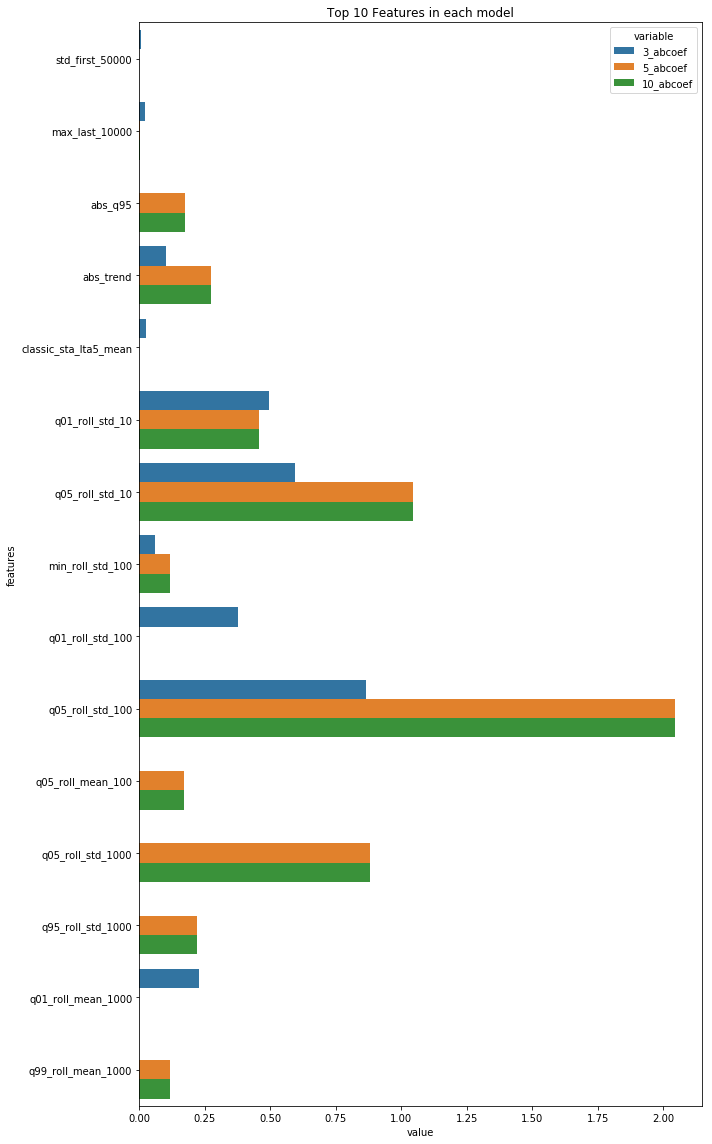

In [56]:
plt.figure(figsize=(10,16))
sns.barplot(x="value", y="features", data=best_features_clong_df, hue="variable")
plt.title('Top 10 Features in each model')
plt.tight_layout()

__Comment:__
* In the linear model, the rolling mean plays more important role than it in the treebased model.
* q05_roll_std_100, q05_roll_std_10, q05_roll_std_1000 